# Bayesian Neural Networks - exercise 05.1
 >__Created__:  2018 Harrison B. Prosper

See __hmc.ipynb__ for details of the Hamiltonian Monte Carlo method, which is used here.

### Exercise
  1. Build Bayesian neural network, from scratch, to discriminate between the the vector boson fusion production mode of the Higgs boson and its production via gluon gluon fusion. Try variables $(\Delta\eta_{jj}, m_{jj})$,  which in the dataframe are $detajj$ and $massjj$, respectively.
  1. Try one and two hidden layers.
  1. Vary the number of nodes/layer

In [41]:
import os, sys
import pandas as pd
import numpy as np

from pprint import PrettyPrinter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.externals import joblib

import matplotlib as mp
import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline

In [42]:
# update fonts
FONTSIZE = 24
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 24}

mp.rc('font', **font)
PP = PrettyPrinter()
pp = PP.pprint

### Load Higgs boson data into memory


In [43]:
train_data, test_data = joblib.load('../03/higgs_vbf_ggf_data.pkl')
train_data[['target','detajj', 'massjj']][:10]

,target,detajj,massjj
52491,0.0,0.71680,49.02
8322,1.0,4.12800,659.10
44929,1.0,0.08639,215.20
46620,1.0,0.48260,16.99
35183,1.0,3.25900,260.40
34752,1.0,5.10700,1364.00
57851,0.0,1.01500,40.95
1400,1.0,3.75200,453.30
13747,0.0,1.22500,56.91
53439,1.0,4.37400,1050.00


### Load previously trained MLP

In [44]:
mlp, scaler = joblib.load("../03/03_dnn_higgs_vbf_ggf.pkl")
mlp, scaler

(MLPClassifier(activation='relu', alpha=0.002, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=(10, 10), learning_rate='constant',
        learning_rate_init=0.001, max_iter=500, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
        solver='sgd', tol=1e-06, validation_fraction=0.1, verbose=0,
        warm_start=False),
 StandardScaler(copy=True, with_mean=True, with_std=True))

### Prepare data for training/testing

In [45]:
inputs  = ['detajj', 'massjj']
X_train = scaler.transform(train_data[inputs]); y_train = train_data['target']
X_test  = scaler.transform(test_data[inputs]); y_test = test_data['target']

### Function to extract biases (intercepts) and weights (coefficients) from an MLP object

In [46]:
def getMLPinfo(mlp, classifier=True):
    from pprint import PrettyPrinter
    pp = PrettyPrinter()
    params = mlp.get_params()
    activation = params['activation']
    B = []
    W = []
    nlayers = len(mlp.intercepts_)
    # width of network
    width = max(map(len, mlp.intercepts_))
    func = []
    for layer in range(nlayers):   
        func.append(activation)
        B.append(mlp.intercepts_[layer])
        W.append(mlp.coefs_[layer])

    if classifier:
        if len(B[-1]) == 1:
            # we have binary classification
            func[-1] = 'logistic'
        else:
            # we have multi-class classification,
            # so we'll be using a softmax later
            func[-1] = 'identity'

    return (B, W, func, width)

In [47]:
B, W, F, width = getMLPinfo(mlp)
print B[0].shape, W[0].shape

(10,) (2, 10)


### Class that implements a DNN class

In [48]:
class DNN:
    """
    Given biases (intercepts) and weights (coefficients), construct a deep neural network. 
    We count layers starting from the first hidden layer, which has layer number zero,
    up to and including the output layer.
        
    Parameters
    ----------
        biases:  A Python list of numpy matrices of shape (n_output,) containing 
        the n_output biases per layer. When interpreted as a matrix, using
                 
            numpy.asmatrix( biases[i] ),  
                 
        biases[i] is a row matrix for layer "i"
                 
        weights: A Python list of (n_inputs, n_outputs)-shaped numpy matrices, 
        where n_inputs is the number of inputs into a layer with n_outputs.
                 
        node_functions: A Python list of strings giving the names of the 
        activation functions. The following are allowed:
                        
            relu(x)     = max(0, x)
            tanh(x)     = (exp(x) - exp(-x))/(exp(x) + exp(-x))
            logistic(x) = 1 / (1 + exp(-x))
            identity(x) = x
                        
    Usage
    -----
    dnn = DNN(B, W, F, classifier=True)
        : :
        
    y = dnn(x)
    
    where x is a list of numpy array.
    ===============================================================================
    """
    import numpy as np
    class Layer:
        pass
        
    def __init__(self, B, W, F, classifier=True):
        self.n_inputs  = len(W[0])
        self.n_outputs = len(W[-1][0])
        self.n_layers  = len(B)
        
        self.classifier= classifier

        self.fmap = {
            'relu':     self.__relu,
            'identity': self.__identity,
            'logistic': self.__logistic,
            'tanh':     self.__tanh
            }
        self.__initialize(B, W, F)
        
    def __del__(self):
        pass
    
    def __call__(self, inputs):
            
        self.__compute(inputs)
        
        if self.classifier:
            # apply a softmax function if we have more than one output
            if self.n_outputs > 1:
                O = np.exp(self.outputs)
                softsum = sum(O)
                O = O / softsum 
                return O
            else:
                x = float(self.outputs[0][0])
                return x
        else:
            if self.n_outputs > 1:
                return self.self.outputs
            else:
                return float(self.outputs[0][0])
            
    def __relu(self, x):
        return [max(0, z) for z in x.tolist()[0]]

    def __identity(self, x):
        return x

    def __logistic(self, x):
        return 1.0/(1 + np.exp(-x))  
    
    def __tanh(self, x):
        return np.tanh(x) 
    
    def __compute(self, inputs):
        I = np.matrix(inputs)
        for layer in range(self.n_layers):
            B = self.weights[layer].B
            W = self.weights[layer].W
            f = self.weights[layer].function
            I = np.matrix(f(B + I * W))
        self.outputs = I
                
    def __initialize(self, B_, W_, f_):
        self.weights = []
        for B, W, f in zip(B_, W_, f_):
            self.weights.append( self.Layer() )
            self.weights[-1].function = self.fmap[f] 
            self.weights[-1].B = B
            self.weights[-1].W = W            
            
    def update(self, B_, W_):
        for i, B, W in zip(range(len(B_)), B_, W_):
            self.weights[i].B = B
            self.weights[i].W = W

### Check DNN class. It should give same output as MLP

In [49]:
dnn = DNN(B, W, F)
y2  = mlp.predict_proba(X_test)
print "%-32s\t%10s\t%10s %10s" % ('inputs', 'target', 'DNN', 'MLP')
for i in range(10):
    x = X_test[i]
    y1 = dnn(x)
    print "%-32s\t%10d\t%10.4f %10.4f" % (x, y_test.iloc[i], y1, y2[i][-1])


inputs                          	    target	       DNN        MLP
[-0.76735825 -0.47952193]       	         0	    0.4769     0.4769
[-0.52541789 -0.05328526]       	         0	    0.4182     0.4182
[-0.6891606  -0.76358036]       	         0	    0.1212     0.1212
[-0.82876176 -0.5804675 ]       	         0	    0.3650     0.3650
[-0.87074707 -0.73236275]       	         1	    0.1724     0.1724
[-0.60938852 -0.55145558]       	         1	    0.3503     0.3503
[-1.25690697 -0.62040855]       	         0	    0.3941     0.3941
[ 1.75018593  2.35112674]       	         1	    0.8714     0.8714
[ 1.28624825  0.13350377]       	         0	    0.5854     0.5854
[ 1.37599185  1.3158386 ]       	         1	    0.8401     0.8401


In [50]:
def plotDistribution(dnn, X_test, y_test, ftsize=FONTSIZE, fgsize=(12,6)):
    
    p = mlp.predict_proba(X_test)
    
    b = map(lambda x: x[0][-1], filter(lambda x: x[-1], zip(p, y_test < 1)))
    
    s = map(lambda x: x[0][-1], filter(lambda x: x[-1], zip(p, y_test > 0)))  
     
    # set size of figure
    plt.figure(figsize=fgsize)

    plt.hist(b, 
             bins=50, 
             color=(1,0,0),
             alpha=0.3,
             range=(0.0,1.0), 
             normed=True, 
             label=r'ggF') 
    pl.legend(fontsize='small') # show legend using specified "label"
    
    plt.hist(s, 
             bins=50, 
             color=(0,1,0),
             alpha=0.3,
             range=(0.0,1.0), 
             normed=True, 
             label=r'VBF') 
    pl.legend(fontsize='small') # show legend using specified "label"
    
    # adjust y limits
    axes = plt.gca()
    ymin, ymax = axes.get_ylim()
    delta = 0.2
    ii = int(1.3*ymax/delta)
    ymax = ii * 0.2
    axes.set_ylim((0, ymax))
    plt.savefig("05_dnn_higgs_vbf_ggf_distribution.png")
    plt.show()

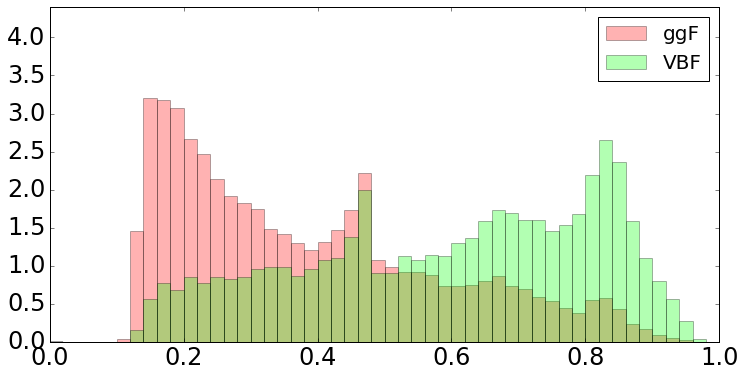

In [51]:
plotDistribution(mlp, X_test, y_test)

In [59]:
def plotResults(mlp, scaler, train_data, test_data, 
                xmin=0, xmax=8, ymin=0, ymax=2000, N=2000,
                ftsize=FONTSIZE):
    
    # split into sig and bkg for the purposes of plotting
    select    = train_data['target'] == 1
    train_sig = train_data[select]
    
    select    = train_data['target'] == 0
    train_bkg = train_data[select]

    select    = test_data['target']  == 1
    test_sig  = test_data[select]
    
    select    = test_data['target']  == 0
    test_bkg  = test_data[select]
    
    # set size of figure
    plt.figure(figsize=(12, 8));

    # get axis info
    axes = plt.gca()
    # set axes' limits
    axes.set_xlim(xmin, xmax)
    axes.set_ylim(ymin, ymax)
    
    # annotate axes
    plt.xlabel(r'$\Delta\eta_{jj}$', fontsize=ftsize)
    plt.ylabel(r'$m_{jj}$ (GeV)', fontsize=ftsize)
    
    # choose color of points
    red = (1,0,0)
    blue= (0,0,1)
    plt.scatter(test_sig['detajj'][:N], test_sig['massjj'][:N], marker='o',
                s=50, c=blue, alpha=0.3, label='VBF')
    pl.legend() # activate legend
    
    plt.scatter(test_bkg['detajj'][:N], test_bkg['massjj'][:N], marker='*',
                s=100, c=red,  alpha=0.3, label='ggF')
    pl.legend() # activate legend
    
    # create a contour plot
    # 1. first create a mesh
    # 2. compute network output at all mesh points
    npoints= 50
    xdelta = float(xmax-xmin)/npoints
    ydelta = float(ymax-ymin)/npoints
    x = np.arange(xmin, xmax, xdelta)
    y = np.arange(ymin, ymax, ydelta)
    X, Y = np.meshgrid(x, y)
    
    # make grid points into a dataframe
    detajj = X.flatten()
    massjj = Y.flatten()
    XY  = pd.DataFrame({'detajj': detajj, 
                        'massjj': massjj})
    
    # apply standardization
    P = scaler.transform(XY)
    # compute network value at every grid point
    # and reshape to a npoints x npoints array
    Z = np.array(map(lambda x: x[-1], mlp.predict_proba(P))).reshape([len(X), len(X)])

    # plot contours
    mylevels = np.arange(0,1,0.05)
    plt.contour(X, Y, Z, levels=mylevels)
    plt.savefig('05_dnn_higgs_vbf_ggf_contours.png')
    plt.show()

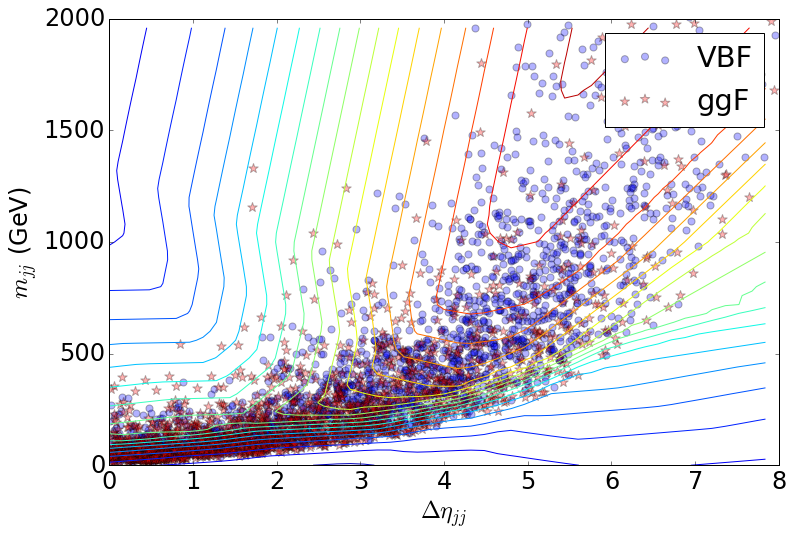

In [60]:
plotResults(mlp, scaler, train_data, test_data)